In [2]:
import numpy as np
import torch

import torchvision
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

from torchsummary import summary

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

In [78]:
data = np.loadtxt(open('sample_data/mnist_train_small.csv', 'rb'), delimiter = ',')
labels = data[:, 0]
data = data[:, 1:]

dataNorm = data/np.max(data)
print(dataNorm.shape)

(20000, 784)


In [79]:
dataNorm.shape
dataNorm = dataNorm.reshape(dataNorm.shape[0], 1, 28, 28)
dataNorm.shape

(20000, 1, 28, 28)

In [80]:
dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long()

train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT, test_size = 0.2, random_state = 42)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

print(train_data.tensors[0].shape, test_data.tensors[0].shape)

batchSize = 32
train_loader = DataLoader(train_data, batch_size = batchSize, shuffle = True, drop_last = True)
test_loader = DataLoader(test_data, batch_size = test_data.tensors[0].shape[0])

torch.Size([16000, 1, 28, 28]) torch.Size([4000, 1, 28, 28])


In [82]:
test_data.tensors[0].shape

torch.Size([4000, 1, 28, 28])

torch.Size([1, 28, 28])


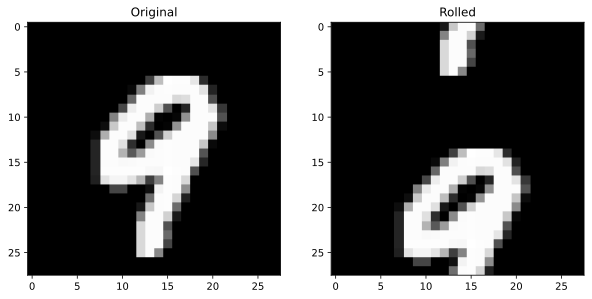

In [86]:
tmp = test_loader.dataset.tensors[0][0, :]
print(tmp.shape)
tmpS = torch.roll(tmp, 8, dims = 1)
fig, axs = plt.subplots(1, 2, figsize = (10, 6))
axs[0].imshow(torch.squeeze(tmp), cmap = 'gray')
axs[0].set_title('Original')

axs[1].imshow(torch.squeeze(tmpS), cmap = 'gray')
axs[1].set_title('Rolled')
plt.show()

In [88]:
for i in range(train_loader.dataset.tensors[0].shape[0]):
  
  # get the image
  img = train_loader.dataset.tensors[0][i,:,:]
  
  # reshape and roll by 10 pixels
  randroll = np.random.randint(-10,11)
  img = torch.roll( img ,randroll,dims=1 )

  # re-vectorize and put back into the matrix
  train_loader.dataset.tensors[0][i,:,:] = img

In [89]:
for i in range(test_loader.dataset.tensors[0].shape[0]):
  
  # get the image
  img = test_loader.dataset.tensors[0][i,:,:]
  
  # reshape and roll by 10 pixels
  randroll = np.random.randint(-10,11)
  img = torch.roll( img ,randroll,dims=1 )

  # re-vectorize and put back into the matrix
  test_loader.dataset.tensors[0][i,:,:] = img


In [90]:
def createMnistNet(printtoggle = False):
  class mnistNet(nn.Module):
    def __init__(self, printtoggle):
      super().__init__()

      self.conv1 = nn.Conv2d(1, 10, kernel_size = 5, stride = 1, padding = 1)

      self.conv2 = nn.Conv2d(10, 20, kernel_size = 5, stride = 1, padding = 1)

      expectSize = np.floor((5+2*0 -1)/1) + 1
      expectSize = 20 * int(expectSize ** 2)

      self.fc1 = nn.Linear(expectSize, 50)
      self.out = nn.Linear(50, 10)
      self.print = printtoggle
      


    def forward(self, x):

      print(f'Input: {x.shape}') if self.print else None

      x = F.relu(F.max_pool2d(self.conv1(x), 2))
      print(f'Layer conv1/pool1: {x.shape}') if self.print else None

      x = F.relu(F.max_pool2d(self.conv2(x), 2))
      print(f'Layer conv2/pool2: {x.shape}') if self.print else None

      nUnits = x.shape.numel()/x.shape[0]
      if self.print: print(nUnits, x.shape.numel(), x.shape[0])
      x = x.view(-1, int(nUnits))

      if self.print: print(f'Vectorize: {x.shape}')

      x = F.relu(self.fc1(x))
      if self.print: print(f'Layer fc1: {x.shape}')
      x = self.out(x)
      if self.print: print(f'Layer out: {x.shape}')

      return x

  net = mnistNet(printtoggle)
  lossfun = nn.CrossEntropyLoss()

  optimizer = torch.optim.Adam(net.parameters(), lr = .001)
  return net, lossfun, optimizer
    

In [91]:
net, lossfun, optimizer = createMnistNet(True)

dataIter = iter(train_loader)
X, y = next(dataIter)
yHat = net(X)

print('')
print(yHat.shape)
print(y.shape)

loss = lossfun(yHat, y)
print('')
print(f'Loss: {loss}')

Input: torch.Size([32, 1, 28, 28])
Layer conv1/pool1: torch.Size([32, 10, 13, 13])
Layer conv2/pool2: torch.Size([32, 20, 5, 5])
500.0 16000 32
Vectorize: torch.Size([32, 500])
Layer fc1: torch.Size([32, 50])
Layer out: torch.Size([32, 10])

torch.Size([32, 10])
torch.Size([32])

Loss: 2.3155364990234375


In [92]:
summary(net, (1, 28, 28))

Input: torch.Size([2, 1, 28, 28])
Layer conv1/pool1: torch.Size([2, 10, 13, 13])
Layer conv2/pool2: torch.Size([2, 20, 5, 5])
500.0 1000 2
Vectorize: torch.Size([2, 500])
Layer fc1: torch.Size([2, 50])
Layer out: torch.Size([2, 10])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             260
            Conv2d-2           [-1, 20, 11, 11]           5,020
            Linear-3                   [-1, 50]          25,050
            Linear-4                   [-1, 10]             510
Total params: 30,840
Trainable params: 30,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.12
Estimated Total Size (MB): 0.19
----------------------------------------------------------------


In [93]:
def function2trainTheModel():

  numepochs = 10
  net, lossfun, optimizer = createMnistNet()

  losses = torch.zeros(numepochs)
  trainAcc = []
  testAcc = []

  for epochi in range(numepochs):
    net.train()
    batchAcc = []
    batchLoss = []

    for X, y in train_loader:
      yHat = net(X)
      loss = lossfun(yHat, y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      

      batchLoss.append(loss.item())

      matches = torch.argmax(yHat, axis = 1) == y
      matchesNumeric = matches.float()
      accuracyPct = 100*torch.mean(matchesNumeric)
      batchAcc.append(accuracyPct)

    trainAcc.append(np.mean(batchAcc))
    losses[epochi] = np.mean(batchLoss)

    net.eval()
    X, y = next(iter(test_loader))
    with torch.no_grad():
      yHat = net(X)

    testAcc.append(100 * torch.mean((torch.argmax(yHat, axis = 1)==y).float()))

  return trainAcc, testAcc, losses, net

In [94]:
trainAcc, testAcc, losses, net = function2trainTheModel()

In [95]:
print(trainAcc, testAcc)

[58.6, 84.19375, 89.35625, 91.5125, 93.0, 94.01875, 94.6375, 95.375, 95.8625, 96.325] [tensor(82.7750), tensor(87.1500), tensor(90.5750), tensor(92.3500), tensor(92.9750), tensor(93.5250), tensor(93.7500), tensor(94.5750), tensor(94.6000), tensor(94.3250)]


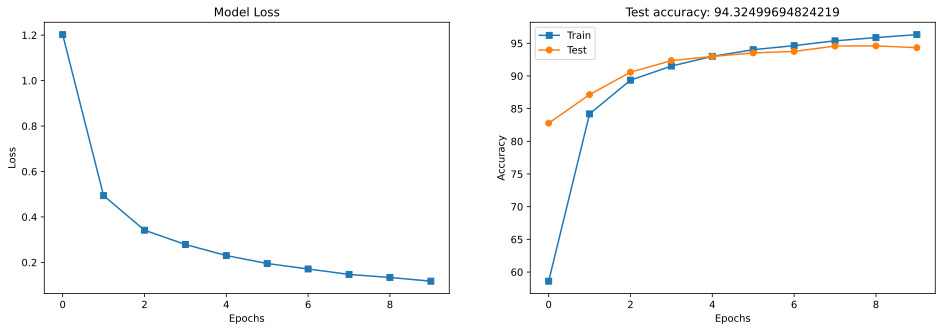

In [96]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))

ax[0].plot(losses, 's-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model Loss')

ax[1].plot(trainAcc, 's-', label = 'Train')
ax[1].plot(testAcc, 'o-', label = 'Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title(f'Test accuracy: {testAcc[-1]}')
ax[1].legend()
plt.show()